==== Head (raw ratios) ====
               PER    PBR    PSR    ROE    ROA  OperatingMargin   ROIC
Date                                                                  
2022-03-31 11.4384 0.6797 0.4287 0.0599 0.0277           0.0451 0.0377
2023-03-31 15.9601 0.7643 0.4713 0.0474 0.0228           0.0438 0.0354
2024-03-31 51.3675 0.6469 0.4557 0.0126 0.0063           0.0234 0.0122
2025-03-31 20.8026 0.9587 0.6392 0.0456 0.0237           0.0497 0.0426


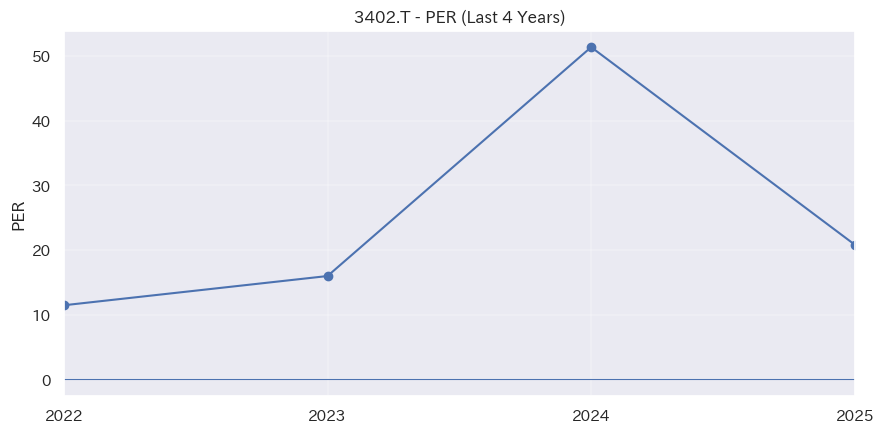

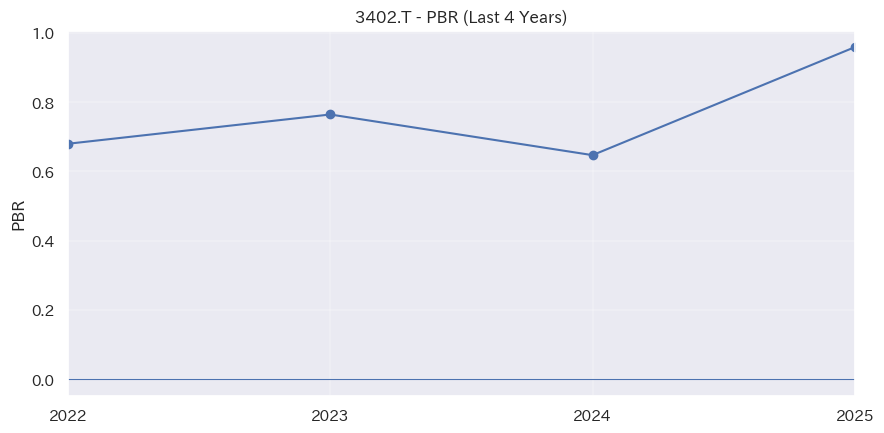

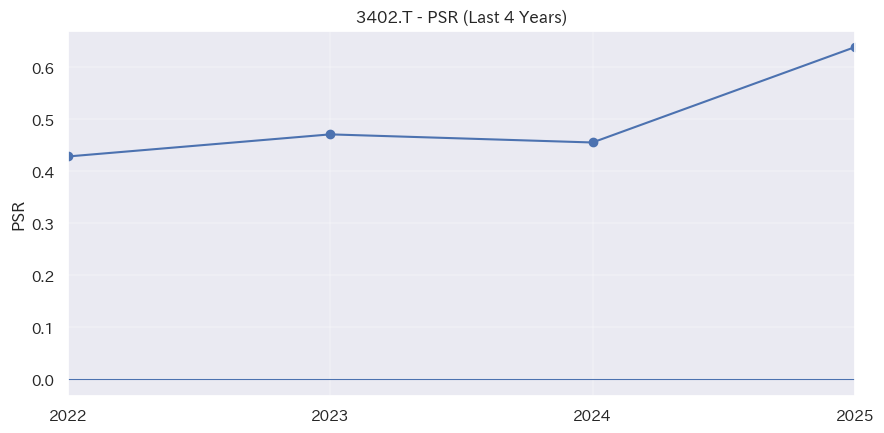

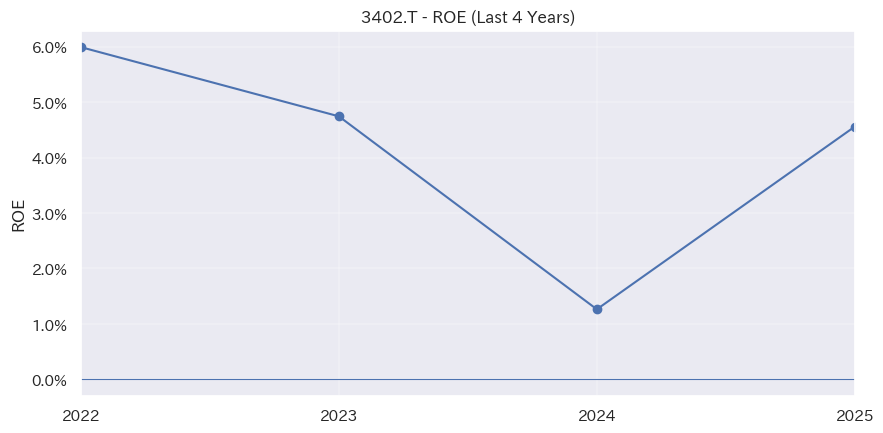

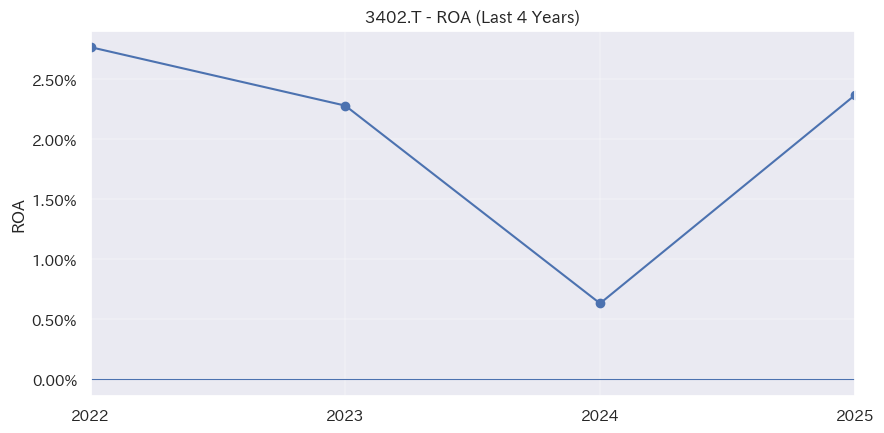

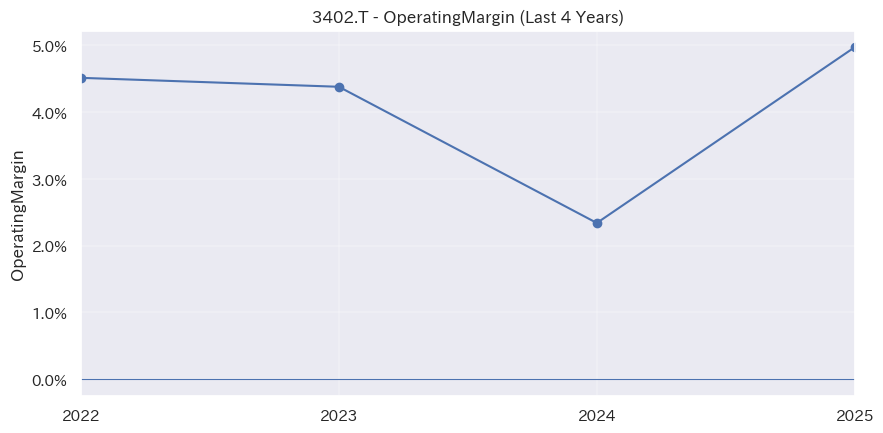

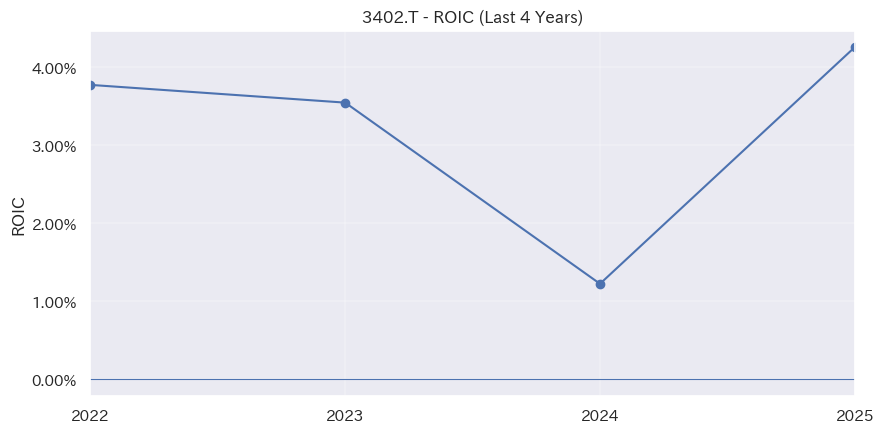

In [4]:
"""
YFinance ratios dashboard for Toray (3402.T)
-------------------------------------------------
• 目的: yfinanceの年次財務データを用いて、以下の指標を過去25年分で算出し、可視化します。
    - PER (Price / Diluted EPS)
    - PBR (Price / BVPS)
    - ROIC ≈ NOPAT / Invested Capital  [NOPAT=EBIT*(1-ETR), Invested=Equity+Debt-Cash]
    - PSR (Market Cap / Revenue)
    - ROE (Net Income / Equity)
    - ROA (Net Income / Total Assets)
    - 営業利益率 (Operating Income / Revenue)

• 依存: yfinance>=0.2.40, pandas, numpy, matplotlib
• 備考: 銘柄は東レ(3402.T)を既定にしていますが、tickerを変更すれば他銘柄にも対応します。
• 注意: yfinanceの財務ラベルは銘柄/IFRS/US-GAAPで異なる場合があります。下の `pick` 候補名を必要に応じて追加してください。
"""

import math
from dataclasses import dataclass
from typing import Optional

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font='IPAexGothic')

pd.options.display.float_format = lambda x: f"{x:,.4f}"

# ============================
# 設定
# ============================
TICKER = "3402.T"  # 東レ
MAX_YEARS = 25      # 取得・表示年数
PRICE_LOOKBACK_DAYS = 10  # 決算日近傍の株価探索ウィンドウ（日）

# ============================
# ユーティリティ
# ============================

def pick(df: pd.DataFrame, candidates: list[str]) -> Optional[pd.Series]:
    """dfの列から最初に見つかった候補名のSeriesを返す（なければNone）。
    dfは期間×項目 の形を想定。
    """
    for c in candidates:
        if c in df.columns:
            return df[c]
    return None


def nearest_price(prices: pd.Series, target_date: pd.Timestamp, lookback_days: int = PRICE_LOOKBACK_DAYS) -> Optional[float]:
    """目標日付の前後±lookbackの範囲で最も近い営業日の終値(Adj Close/Close)を返す。無ければNone。
    prices: 日次の終値 Series か、'Adj Close'/'Close' 列を含むDataFrame。
    """
    # Seriesに統一
    s = prices
    if isinstance(s, pd.DataFrame):
        if "Adj Close" in s.columns:
            s = s["Adj Close"]
        elif "Close" in s.columns:
            s = s["Close"]
        elif s.shape[1] == 1:
            s = s.squeeze("columns")
        else:
            raise TypeError("`prices` must be a Series or a DataFrame with 'Close'/'Adj Close'.")
    s = s.sort_index()

    if target_date.tzinfo is not None:
        target_date = target_date.tz_convert(None).tz_localize(None)
    start = target_date - pd.Timedelta(days=lookback_days)
    end = target_date + pd.Timedelta(days=lookback_days)
    window = s.loc[(s.index >= start) & (s.index <= end)]
    if window.empty:
        return None
    # 最も近い日付（位置ベースで取得）
    deltas = (window.index - target_date)
    abs_ns = np.abs(deltas.to_numpy().astype('timedelta64[ns]').astype('int64'))
    nearest_pos = int(abs_ns.argmin())
    val = window.iloc[nearest_pos]
    # 将来のpandasでも警告が出ないように必ずスカラー化
    if isinstance(val, (pd.Series, pd.DataFrame)):
        val = getattr(val, "squeeze", lambda: val)()
        if isinstance(val, (pd.Series, pd.DataFrame)):
            val = np.asarray(val).reshape(-1)[0]
    return float(val)


@dataclass
class FinancialBlocks:
    inc: pd.DataFrame  # 期間×項目 (income statement)
    bal: pd.DataFrame  # 期間×項目 (balance sheet)
    cfs: pd.DataFrame  # 期間×項目 (cash flow)


def load_financials(ticker: str) -> FinancialBlocks:
    tkr = yf.Ticker(ticker)

    # yfinanceの各DFは index=項目, columns=期末日 なので転置。
    inc = tkr.income_stmt.T.copy()
    bal = tkr.balance_sheet.T.copy()
    cfs = tkr.cashflow.T.copy()

    # 列名（項目名）を統一タイプへ（スペース/大文字は維持、yfinance準拠）
    inc.columns = inc.columns.astype(str)
    bal.columns = bal.columns.astype(str)
    cfs.columns = cfs.columns.astype(str)

    # 日付IndexをDatetimeへ（UTC→naive）
    for df in (inc, bal, cfs):
        df.index = pd.to_datetime(df.index).tz_localize(None)
        df.sort_index(inplace=True)

    return FinancialBlocks(inc=inc, bal=bal, cfs=cfs)


def build_ratio_table(ticker: str, max_years: int = MAX_YEARS) -> pd.DataFrame:
    fb = load_financials(ticker)

    # 主要財務項目の取り出し（候補名はIFRS/USGAAP差を吸収するため複数）
    revenue = pick(fb.inc, ["Total Revenue", "Revenues", "Operating Revenue", "Revenue"])
    op_inc = pick(fb.inc, ["Operating Income", "Operating Income (Loss)", "OperatingIncome", "EBIT"])
    pretax = pick(fb.inc, ["Pretax Income", "Income Before Tax", "Earnings Before Tax"])
    tax = pick(fb.inc, ["Tax Provision", "Income Tax Expense", "Provision for Income Taxes"])
    net_inc = pick(fb.inc, ["Net Income", "Net Income Common Stockholders", "NetIncome"])
    eps_dil = pick(fb.inc, ["Diluted EPS", "Diluted EPS (cont. ops)", "Diluted EPS Total"])
    basic_shares = pick(fb.inc, ["Basic Average Shares", "Basic Shares Outstanding", "Basic Weighted Average Shares"])

    equity = pick(fb.bal, ["Stockholders Equity", "Total Stockholder Equity", "Total Equity Gross Minority Interest", "Total Equity"])
    assets = pick(fb.bal, ["Total Assets", "Assets"])
    lt_debt = pick(fb.bal, ["Long Term Debt", "Long Term Debt And Capital Lease Obligation"])
    st_debt = pick(fb.bal, ["Short Long Term Debt", "Current Debt", "Short Term Debt"])
    cash = pick(fb.bal, ["Cash And Cash Equivalents", "Cash Cash Equivalents And Short Term Investments", "Cash And Equivalents"])

    # 欠落が多い場合はエラー
    needed = {
        'revenue': revenue, 'op_inc': op_inc, 'pretax': pretax, 'tax': tax, 'net_inc': net_inc,
        'equity': equity, 'assets': assets
    }
    missing = [k for k, v in needed.items() if v is None]
    if missing:
        raise RuntimeError(f"必要な項目が不足しています: {missing}. yfinanceの項目名をprintして候補を追加してください。\n"
                           f"income_stmt cols: {list(fb.inc.columns)[:20]}...\n"
                           f"balance_sheet cols: {list(fb.bal.columns)[:20]}...")

    # 投下資本
    total_debt = (st_debt if st_debt is not None else 0)
    if isinstance(total_debt, (int, float)):
        total_debt = pd.Series(0, index=fb.bal.index)
    if lt_debt is not None:
        total_debt = total_debt.add(lt_debt, fill_value=0)
    if cash is None:
        cash = pd.Series(0, index=fb.bal.index)
    invested_capital = equity.add(total_debt, fill_value=0).sub(cash, fill_value=0)

    # 税率・NOPAT
    etr = None
    if (pretax is not None) and (tax is not None):
        with np.errstate(divide='ignore', invalid='ignore'):
            etr = (tax / pretax).replace([np.inf, -np.inf], np.nan).clip(lower=0, upper=0.5)
    if etr is None or etr.isna().all():
        # フォールバック固定税率（保守的に25%）
        etr = pd.Series(0.25, index=fb.inc.index)
    ebit = op_inc
    nopat = ebit * (1 - etr)

    # 株価・時価総額（期末近傍）
    start = (fb.inc.index.min() - pd.Timedelta(days=370)).date().isoformat()
    end = (fb.inc.index.max() + pd.Timedelta(days=370)).date().isoformat()
    px = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)["Close"]

    # 発行株式数（年末近傍）。詳細が取れない場合はBasic Average Sharesを代替
    tkr = yf.Ticker(ticker)
    try:
        shares_full = tkr.get_shares_full(start=start, end=end)
        if shares_full is not None and not shares_full.empty:
            shares_full.index = pd.to_datetime(shares_full.index).tz_localize(None)
            shares_full = shares_full.sort_index()
        else:
            shares_full = None
    except Exception:
        shares_full = None

    def shares_at(d: pd.Timestamp) -> Optional[float]:
        if shares_full is not None:
            s = shares_full[shares_full.index <= d]
            if not s.empty:
                return float(s.iloc[-1])
        # フォールバック: 基本平均株式数（年平均）
        if basic_shares is not None:
            # 最も近い期の値（位置ベースで取得）
            deltas = (basic_shares.index - d)
            abs_ns = np.abs(deltas.to_numpy().astype('timedelta64[ns]').astype('int64'))
            nearest_pos = int(abs_ns.argmin())
            return float(basic_shares.iloc[nearest_pos])
        # 最終フォールバック: fast_info
        try:
            return float(tkr.fast_info.get("shares_outstanding"))
        except Exception:
            return None

    # 期ごとの指標を計算
    rows = []
    for d in fb.inc.index:
        price = nearest_price(px, d, lookback_days=PRICE_LOOKBACK_DAYS)
        sh = shares_at(d)
        rev = revenue.get(d, np.nan)
        ebit_d = ebit.get(d, np.nan)
        net = net_inc.get(d, np.nan)
        eq = equity.get(d, np.nan)
        asset = assets.get(d, np.nan)
        ic = invested_capital.get(d, np.nan)
        eps = np.nan
        if eps_dil is not None and d in eps_dil.index:
            eps = eps_dil.get(d, np.nan)
        elif (sh is not None) and not math.isnan(sh):
            eps = net / sh if sh else np.nan

        # バリュエーション用
        mktcap = (price * sh) if (price is not None and sh is not None) else np.nan
        bvps = (eq / sh) if (sh is not None and sh) else np.nan

        # 指標算出
        per = (price / eps) if (price is not None and eps and eps > 0) else np.nan
        pbr = (price / bvps) if (price is not None and bvps and bvps != 0) else np.nan
        psr = (mktcap / rev) if (not pd.isna(mktcap) and rev and rev != 0) else np.nan
        roe = (net / eq) if (eq and eq != 0) else np.nan
        roa = (net / asset) if (asset and asset != 0) else np.nan
        op_margin = (ebit_d / rev) if (rev and rev != 0) else np.nan
        roic = (nopat.get(d, np.nan) / ic) if (ic and ic != 0) else np.nan

        rows.append({
            "Date": d,
            "Price": price,
            "Shares": sh,
            "Revenue": rev,
            "OperatingIncome": ebit_d,
            "NetIncome": net,
            "Equity": eq,
            "Assets": asset,
            "InvestedCapital": ic,
            "DilutedEPS": eps,
            "MarketCap": mktcap,
            "BVPS": bvps,
            # Ratios
            "PER": per,
            "PBR": pbr,
            "PSR": psr,
            "ROE": roe,
            "ROA": roa,
            "OperatingMargin": op_margin,
            "ROIC": roic,
        })

    df = pd.DataFrame(rows).set_index("Date").sort_index()
    # 直近MAX_YEARS年に絞る
    df = df.tail(max_years)
    return df


def plot_ratios(ratio_df: pd.DataFrame):
    """各比率を個別プロット（matplotlib）。色は指定しない（環境既定）。"""
    ratio_cols = ["PER", "PBR", "PSR", "ROE", "ROA", "OperatingMargin", "ROIC"]
    for col in ratio_cols:
        if col not in ratio_df.columns:
            continue
        plt.figure(figsize=(9, 4.5))
        ratio_df[col].astype(float).plot(marker="o")
        plt.title(f"{TICKER} - {col} (Last {len(ratio_df)} Years)")
        if col in ("ROE", "ROA", "OperatingMargin", "ROIC"):
            plt.ylabel(col)
            plt.axhline(0, linewidth=0.8)
            plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1))
        else:
            plt.ylabel(col)
            plt.axhline(0, linewidth=0.8)
        plt.xlabel('')
        plt.grid(True, linewidth=0.3)
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    ratios = build_ratio_table(TICKER, MAX_YEARS)
    print("==== Head (raw ratios) ====")
    print(ratios[["PER","PBR","PSR","ROE","ROA","OperatingMargin","ROIC"]].head())
    plot_ratios(ratios)